In [1]:
import sys; sys.path.append('../utils')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tight_plot import tight_plot
from customcolors import *
import nnViz

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
%matplotlib notebook

# Generate Synthetic Data

In [4]:
numSyntheticSamples = 100000
syntheticDataRange = np.linspace( 0, np.pi*numSyntheticSamples/10.0, numSyntheticSamples)
syntheticData = np.sin( syntheticDataRange ) \
                    * np.random.randint( 1, 10, size = numSyntheticSamples ) * 1/2. \
                    + np.random.randint( -1, 1, size = numSyntheticSamples ) * 1/2.

In [5]:
if syntheticData.ndim < 2:
    syntheticData = np.expand_dims(syntheticData, axis=1)

<IPython.core.display.Javascript object>


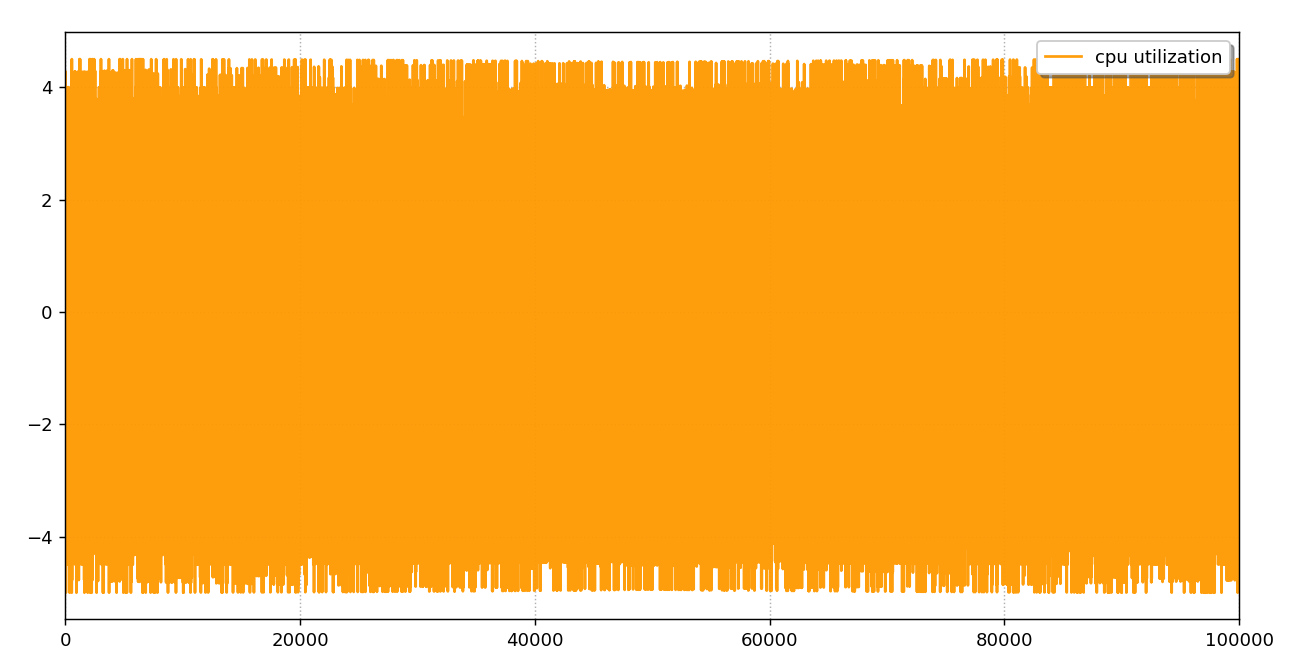

In [6]:
tight_plot(syntheticData, rawDataColor,'cpu utilization')

# Define Model Hyper-parameters

In [7]:
# Define hyperparameters

# of samples per sensor for the micro model [sliding window of ~2.5 hrs]
hParams = {}

hParams['windowSamples'] = 30
hParams['bottleNeckUnits'] = 5
hParams['nSensors'] = 1
hParams['overlapPercentage'] = .99
hParams['advanceSamples'] = ( hParams['windowSamples'] - int( np.floor( hParams['windowSamples'] * hParams['overlapPercentage'] ) ))

# Split into train and test set (.25 test data)

In [8]:
def train_test_split (x, testDataRatio = .25, trainDataAtStart = True):
    assert x.ndim > 1
    if trainDataAtStart:
        splitIndex = int( ( 1.0 - testDataRatio) * x.shape[0] )    
        
        xTrain = x[ 0:splitIndex, :]
        xTest = x[ splitIndex:, :]
    else:
        splitIndex = int( testDataRatio * x.shape[0] )
        xTest = x[ 0:splitIndex, :]
        xTrain = x[ splitIndex:, :]
        
    return xTrain, xTest

In [9]:
trainSplit, testSplit = train_test_split( syntheticData )

# Normalize data ( 0 mean, unit standard deviation )

In [10]:
# find normalization statistics
trainMeans = np.mean(trainSplit, axis=0)
trainSTDevs = np.std(trainSplit, axis=0)
print(trainMeans); print(trainSTDevs)

# normalize [ in place / overwrite ]
normalizedTrainData = (trainSplit - trainMeans) / (trainSTDevs + .0001)
normalizedTestData = (testSplit - trainMeans) / (trainSTDevs + .0001)

[-0.25003615]
[2.00787306]


# Generate Overlapping Windows

In [11]:
def reshape_into_shuffled_data_windows ( x, windowSize, advanceSamples ):
    nWindows = int( np.floor( (x.shape[0] - windowSize)/(advanceSamples*1.0) ) )
    # shuffle indexes
    shuffledWindowInds = np.arange(nWindows)
    np.random.shuffle(shuffledWindowInds)    
        
    nSensors = x.shape[1]
    outputMatrix = np.zeros((nWindows, windowSize * nSensors))
    
    # update data matrix on a row by row basis (choosing shuffled windows per row)
    for iWindow in range(nWindows):
        startIndex = shuffledWindowInds[iWindow] * advanceSamples
        endIndex = startIndex + windowSize
        
        # flatten/interleave sensor values
        for iSensor in range(nSensors):
            outputMatrix[iWindow, iSensor::nSensors] = x[startIndex:endIndex, iSensor]
    
    return outputMatrix, shuffledWindowInds


<IPython.core.display.Javascript object>


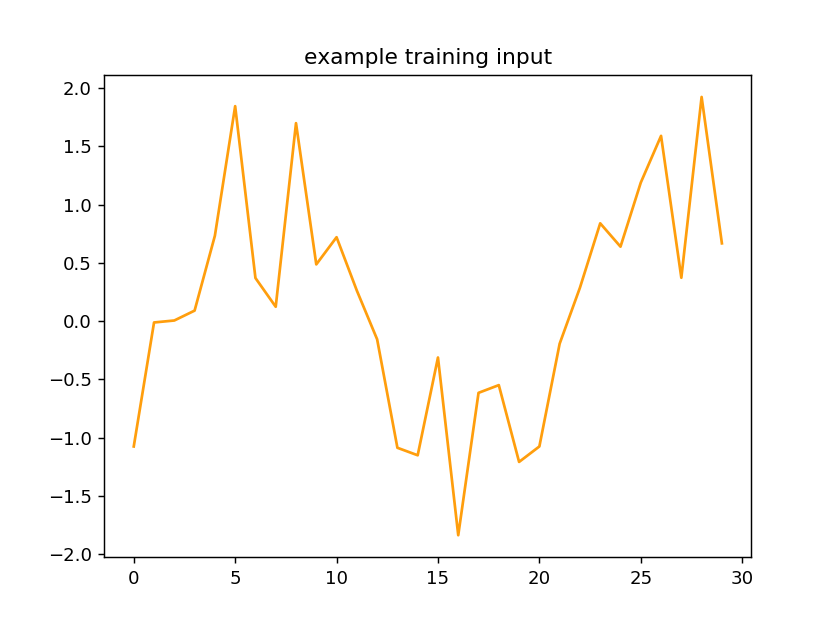

Text(0.5,1,'example training input')

In [12]:
trainMatrix, trainShuffledWindowInds = reshape_into_shuffled_data_windows(normalizedTrainData, hParams['windowSamples'], hParams['advanceSamples'])
testMatrix, testShuffledWindowInds = reshape_into_shuffled_data_windows(normalizedTestData, hParams['windowSamples'], hParams['advanceSamples'])

plt.figure()
plt.plot(trainMatrix[204,:], color = rawDataColor)
plt.title('example training input')

# ML/DL Imports

In [13]:
from keras.models import Sequential, Model
from keras.layers import Dense
from keras import metrics
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Model Architecture

In [14]:
hParams['inputOutputDimensionality'] = int( hParams['windowSamples'] * hParams['nSensors'] ) 
assert hParams['inputOutputDimensionality'] == trainMatrix.shape[1]

In [15]:
# Define model
model = Sequential()


model.add( Dense( 20, input_dim = hParams['inputOutputDimensionality'], activation = 'linear'))

model.add( Dense( 10, activation = 'sigmoid'))

model.add( Dense( hParams['bottleNeckUnits'], activation = 'sigmoid'))

model.add( Dense( 10, activation = 'sigmoid'))

model.add( Dense( 20, activation = 'sigmoid'))

model.add( Dense( hParams['inputOutputDimensionality'], activation = 'linear',))


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_4 (Dense)              (None, 10)                60        
_________________________________________________________________
dense_5 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_6 (Dense)              (None, 30)                630       
Total params: 1,795
Trainable params: 1,795
Non-trainable params: 0
_________________________________________________________________


<IPython.core.display.Javascript object>


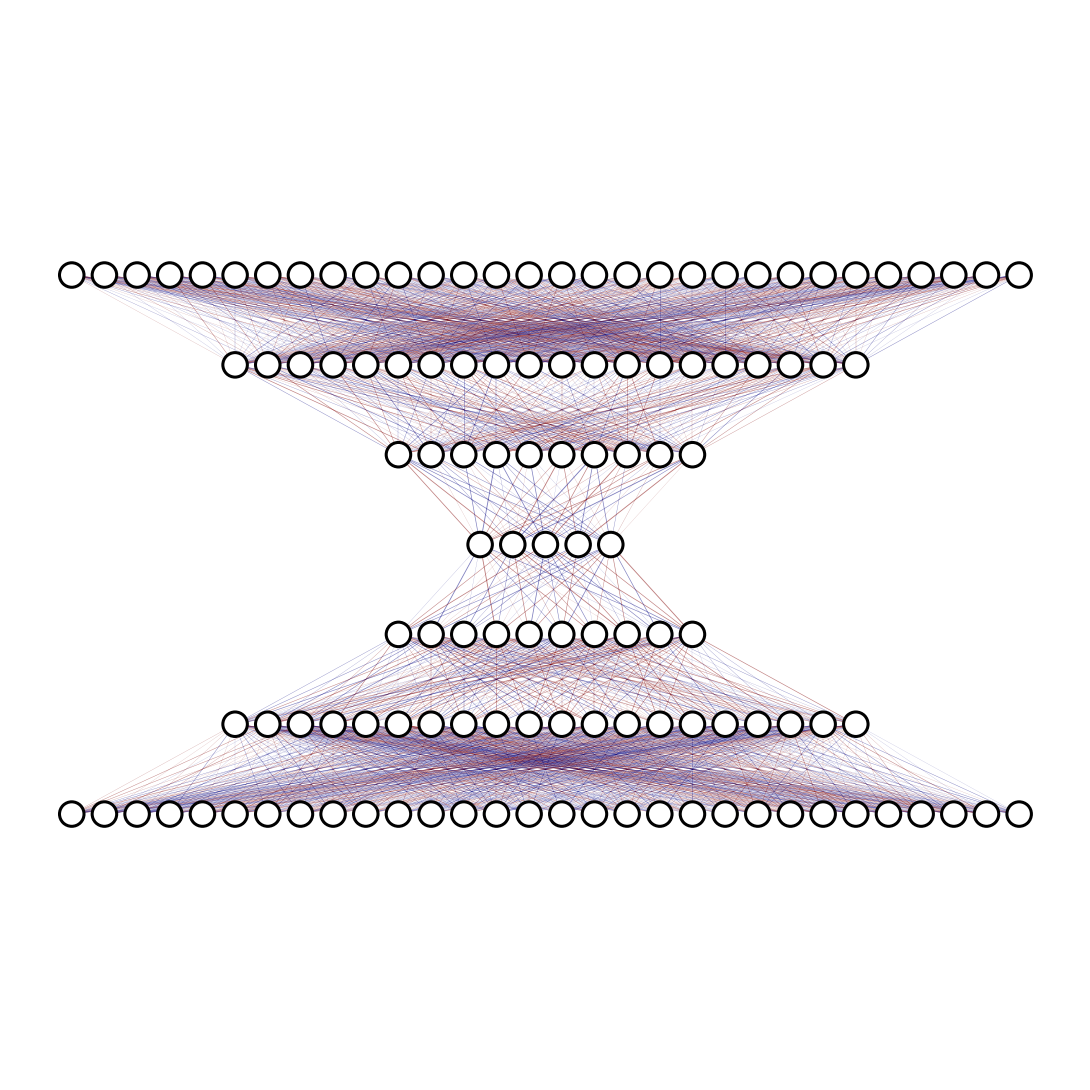

In [16]:
plt.figure(figsize=(10,10))
plt.subplots_adjust( left = 0.01, right = 0.99, top = 0.99, bottom = 0.01, wspace = 0.01 )
nnViz.visualize_model(model)

In [17]:
model.compile(optimizer = 'adam', loss = 'mse')

# Train Model

In [18]:
early_stopping = EarlyStopping( monitor = 'val_loss', patience = 10)
checkpointer = ModelCheckpoint( filepath = 'synthetic_sin_weights_2.hdf5', verbose=1, save_best_only = True)

# keras version 2+
history = model.fit( trainMatrix, trainMatrix,
               batch_size = 256, epochs = 200,
               shuffle = True,
               callbacks = [early_stopping, checkpointer],
               validation_data = (testMatrix, testMatrix) )
'''

# keras version 1.2
history = model.fit( trainMatrix, trainMatrix,
               batch_size = 256, nb_epoch = 15,
               shuffle = True,
               callbacks = [early_stopping, checkpointer],
               validation_data = (testMatrix, testMatrix) )
'''


Train on 74970 samples, validate on 24970 samples
Epoch 1/200
74970/74970 [==============================] - 9s 117us/step - loss: 0.9507 - val_loss: 0.7387

Epoch 00001: val_loss improved from inf to 0.73875, saving model to synthetic_sin_weights_2.hdf5
Epoch 2/200
74970/74970 [==============================] - 1s 19us/step - loss: 0.6315 - val_loss: 0.6079

Epoch 00002: val_loss improved from 0.73875 to 0.60786, saving model to synthetic_sin_weights_2.hdf5
Epoch 3/200
74970/74970 [==============================] - 1s 19us/step - loss: 0.5867 - val_loss: 0.5043

Epoch 00003: val_loss improved from 0.60786 to 0.50429, saving model to synthetic_sin_weights_2.hdf5
Epoch 4/200
74970/74970 [==============================] - 1s 19us/step - loss: 0.2827 - val_loss: 0.2207

Epoch 00004: val_loss improved from 0.50429 to 0.22070, saving model to synthetic_sin_weights_2.hdf5
Epoch 5/200
74970/74970 [==============================] - 1s 19us/step - loss: 0.2174 - val_loss: 0.2178

Epoch 00005: v

74970/74970 [==============================] - 1s 19us/step - loss: 0.2015 - val_loss: 0.2027

Epoch 00041: val_loss improved from 0.20279 to 0.20269, saving model to synthetic_sin_weights_2.hdf5
Epoch 42/200
74970/74970 [==============================] - 1s 19us/step - loss: 0.2014 - val_loss: 0.2027

Epoch 00042: val_loss did not improve from 0.20269
Epoch 43/200
74970/74970 [==============================] - 1s 19us/step - loss: 0.2014 - val_loss: 0.2026

Epoch 00043: val_loss improved from 0.20269 to 0.20263, saving model to synthetic_sin_weights_2.hdf5
Epoch 44/200
74970/74970 [==============================] - 1s 19us/step - loss: 0.2014 - val_loss: 0.2027

Epoch 00044: val_loss did not improve from 0.20263
Epoch 45/200
74970/74970 [==============================] - 1s 19us/step - loss: 0.2013 - val_loss: 0.2027

Epoch 00045: val_loss did not improve from 0.20263
Epoch 46/200
74970/74970 [==============================] - 1s 19us/step - loss: 0.2013 - val_loss: 0.2026

Epoch 0004

Epoch 86/200
74970/74970 [==============================] - 1s 19us/step - loss: 0.1969 - val_loss: 0.1975

Epoch 00086: val_loss improved from 0.19901 to 0.19752, saving model to synthetic_sin_weights_2.hdf5
Epoch 87/200
74970/74970 [==============================] - 1s 19us/step - loss: 0.1955 - val_loss: 0.1965

Epoch 00087: val_loss improved from 0.19752 to 0.19647, saving model to synthetic_sin_weights_2.hdf5
Epoch 88/200
74970/74970 [==============================] - 1s 19us/step - loss: 0.1948 - val_loss: 0.1960

Epoch 00088: val_loss improved from 0.19647 to 0.19598, saving model to synthetic_sin_weights_2.hdf5
Epoch 89/200
74970/74970 [==============================] - 1s 19us/step - loss: 0.1946 - val_loss: 0.1957

Epoch 00089: val_loss improved from 0.19598 to 0.19568, saving model to synthetic_sin_weights_2.hdf5
Epoch 90/200
74970/74970 [==============================] - 1s 19us/step - loss: 0.1944 - val_loss: 0.1956

Epoch 00090: val_loss improved from 0.19568 to 0.19563, 

Epoch 131/200
74970/74970 [==============================] - 1s 19us/step - loss: 0.1935 - val_loss: 0.1949

Epoch 00131: val_loss did not improve from 0.19482
Epoch 132/200
74970/74970 [==============================] - 1s 19us/step - loss: 0.1935 - val_loss: 0.1949

Epoch 00132: val_loss did not improve from 0.19482
Epoch 133/200
74970/74970 [==============================] - 1s 19us/step - loss: 0.1935 - val_loss: 0.1948

Epoch 00133: val_loss did not improve from 0.19482
Epoch 134/200
74970/74970 [==============================] - 1s 19us/step - loss: 0.1935 - val_loss: 0.1948

Epoch 00134: val_loss improved from 0.19482 to 0.19479, saving model to synthetic_sin_weights_2.hdf5
Epoch 135/200
74970/74970 [==============================] - 1s 19us/step - loss: 0.1935 - val_loss: 0.1950

Epoch 00135: val_loss did not improve from 0.19479
Epoch 136/200
74970/74970 [==============================] - 1s 19us/step - loss: 0.1934 - val_loss: 0.1948

Epoch 00136: val_loss improved from 0.194

Epoch 176/200
74970/74970 [==============================] - 1s 19us/step - loss: 0.1863 - val_loss: 0.1877

Epoch 00176: val_loss did not improve from 0.18766
Epoch 177/200
74970/74970 [==============================] - 1s 19us/step - loss: 0.1863 - val_loss: 0.1876

Epoch 00177: val_loss improved from 0.18766 to 0.18761, saving model to synthetic_sin_weights_2.hdf5
Epoch 178/200
74970/74970 [==============================] - 1s 19us/step - loss: 0.1862 - val_loss: 0.1875

Epoch 00178: val_loss improved from 0.18761 to 0.18753, saving model to synthetic_sin_weights_2.hdf5
Epoch 179/200
74970/74970 [==============================] - 1s 19us/step - loss: 0.1862 - val_loss: 0.1875

Epoch 00179: val_loss improved from 0.18753 to 0.18753, saving model to synthetic_sin_weights_2.hdf5
Epoch 180/200
74970/74970 [==============================] - 1s 19us/step - loss: 0.1861 - val_loss: 0.1875

Epoch 00180: val_loss improved from 0.18753 to 0.18749, saving model to synthetic_sin_weights_2.hdf5


'\n\n# keras version 1.2\nhistory = model.fit( trainMatrix, trainMatrix,\n               batch_size = 256, nb_epoch = 15,\n               shuffle = True,\n               callbacks = [early_stopping, checkpointer],\n               validation_data = (testMatrix, testMatrix) )\n'

<IPython.core.display.Javascript object>


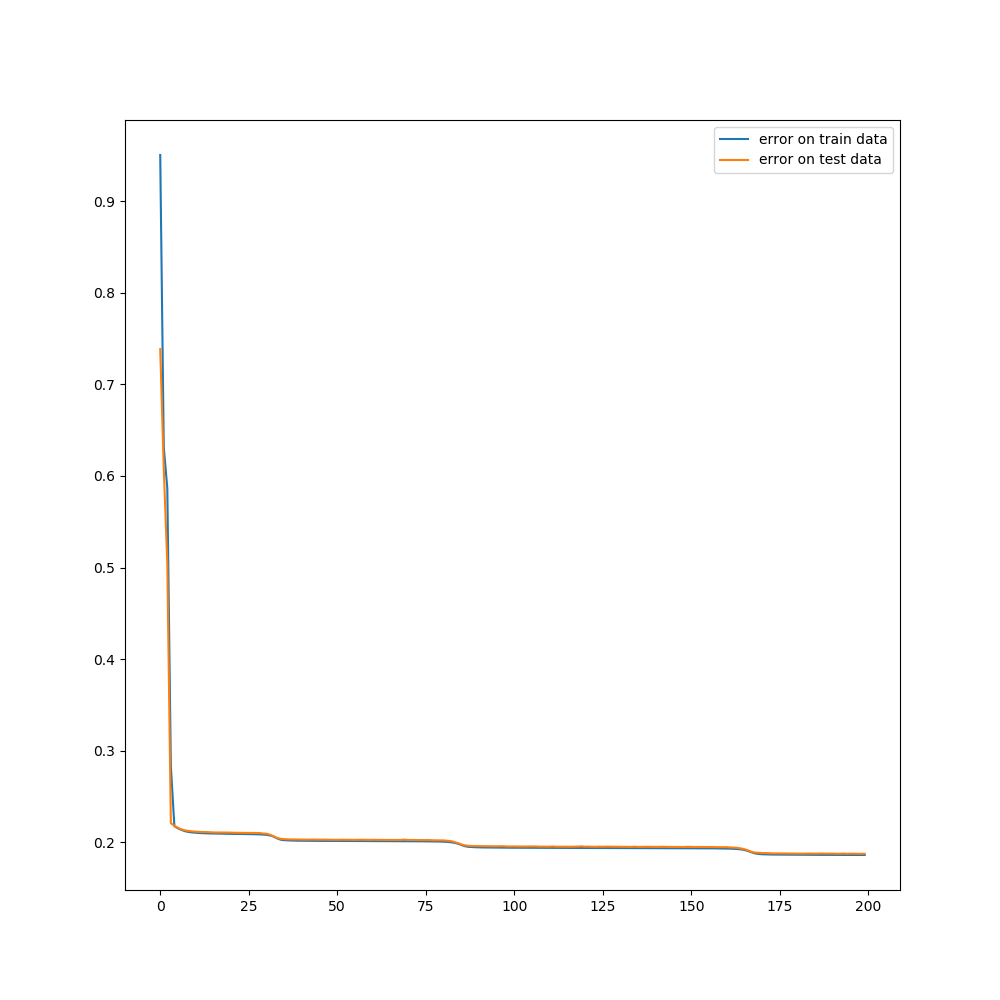

In [19]:
plt.figure( figsize = (10,10) )
plt.plot( history.history['loss'] )
plt.plot( history.history['val_loss'] )
plt.legend(['error on train data', 'error on test data'])

# Load Best Weights [ on validation data ]

In [20]:
model.load_weights("synthetic_sin_weights_2.hdf5")
model.compile(optimizer = 'adam', loss = 'mse') # need to recompile model to be able to run prediction

# Create Anomalies, and Mix/Insert into Training Data

<IPython.core.display.Javascript object>


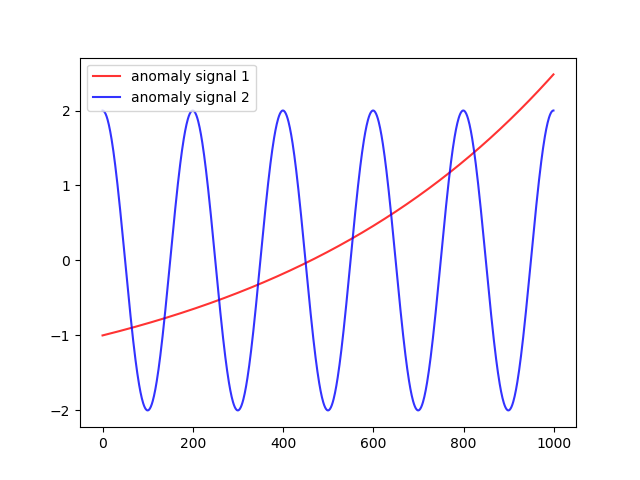

In [21]:
anomalySignal1 = np.exp(np.linspace(0, 1.5, 1000)) - 2
anomalySignal2 = np.cos(np.linspace(0,2*np.pi * 5, 1000)) * 2

anomalySignal1 = np.expand_dims(anomalySignal1, axis=1)
anomalySignal2 = np.expand_dims(anomalySignal2, axis=1)

plt.figure()

plt.plot(anomalySignal1, color = anomalyColor1)
plt.plot(anomalySignal2, color = anomalyColor2)

plt.legend(['anomaly signal 1', 'anomaly signal 2'])

In [22]:
startIndex = 0
endIndex = 3000
anomalyLen1 = len(anomalySignal1)
anomalyLen2 = len(anomalySignal1)

In [24]:
targetData = normalizedTestData[startIndex:endIndex]

anomalyStartIndex_1 = 500
anomalyEndIndex_1 = anomalyStartIndex_1 + anomalyLen1

targetData[anomalyStartIndex_1:anomalyEndIndex_1] = anomalySignal1

anomalyStartIndex_2 = 2000
anomalyEndIndex_2 = anomalyStartIndex_2 + anomalyLen2

targetData[anomalyStartIndex_2:anomalyEndIndex_2] = anomalySignal2


anomalousInds_1 = np.arange(int(anomalyStartIndex_1/hParams['windowSamples']), int(anomalyEndIndex_1/hParams['windowSamples']), dtype=int)
anomalousInds_2 = np.arange(int(anomalyStartIndex_2/hParams['windowSamples']), int(anomalyEndIndex_2/hParams['windowSamples']), dtype=int)

# Plot Target/Raw vs Predicted Data

In [25]:
from sliding_window_inference import windowed_predict, windowed_predict_bottleneck_activation
predictedData = windowed_predict ( model, targetData, hParams['inputOutputDimensionality'])
error = np.sqrt((targetData - predictedData)**2)

number of windows: 100


<IPython.core.display.Javascript object>


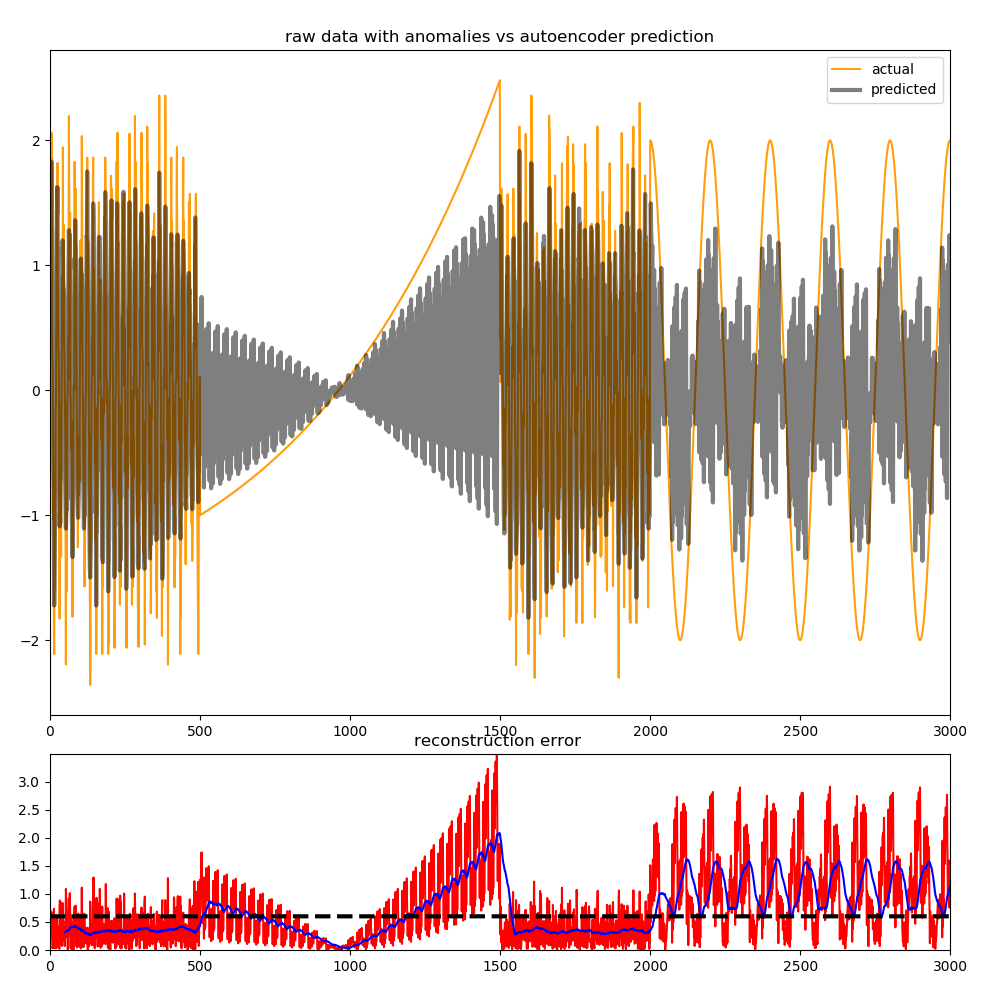

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:15: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


Text(0.5,1,'reconstruction error ')

In [26]:
plt.figure( figsize = (10,10) )

ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
ax2 = plt.subplot2grid((4, 1), (3, 0), rowspan=1, sharex=ax1)
plt.subplots_adjust( left = 0.05, right = 0.95, top = 0.95, bottom = 0.05, wspace = 0.01 )

ax1.plot(targetData, color = rawDataColor)
ax1.plot(predictedData, color = contrastColor2, linewidth=3)
ax1.set_title('raw data with anomalies vs autoencoder prediction')
ax1.legend(['actual', 'predicted'])


ax2.autoscale(enable=True, axis='both', tight=True)
ax2.plot(error, 'r')
rollingMean = pd.rolling_mean (error, window=50)
ax2.plot(rollingMean, 'b')

threshLine = np.ones((len(rollingMean),1)) * .6
ax2.plot(threshLine, 'k--', linewidth = 3)
ax2.set_title('reconstruction error ')

## Remove Last Two Layers [ focus on bottleneck activations ]

<IPython.core.display.Javascript object>


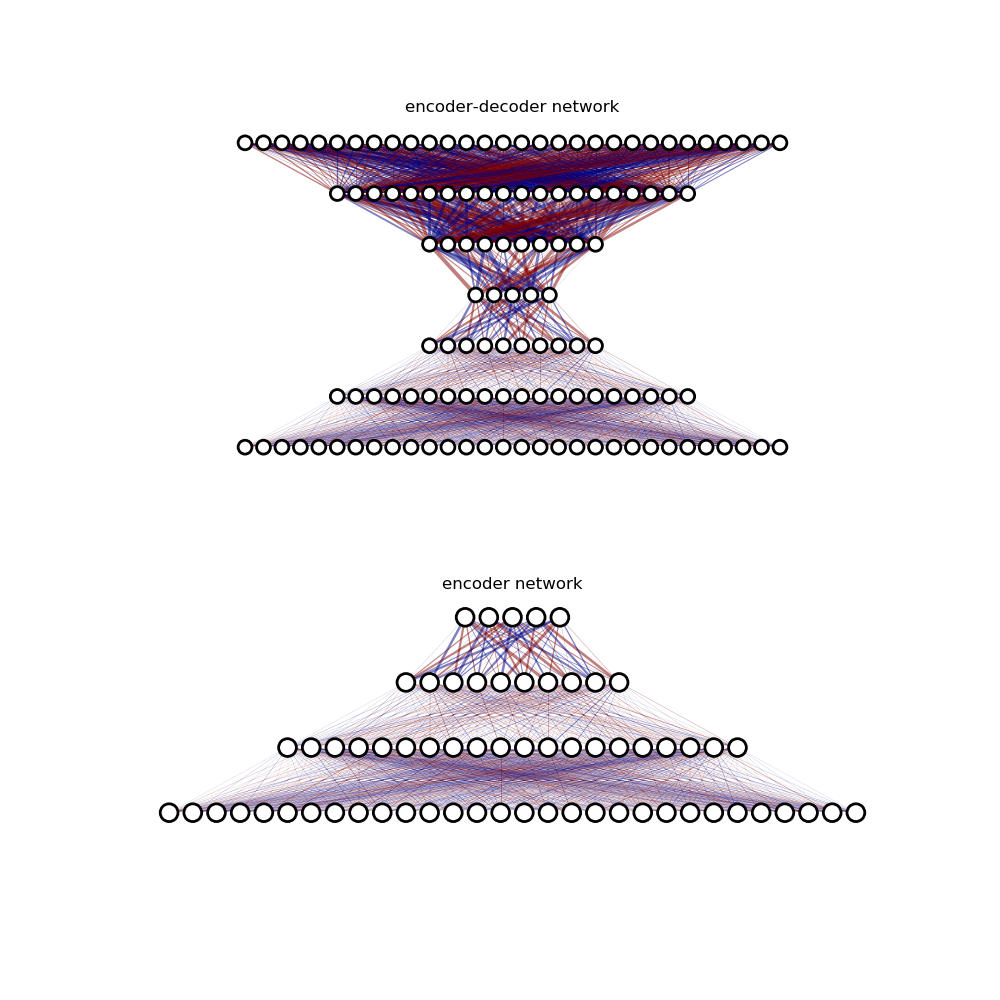

Text(0.5,1,'encoder network')

In [27]:
plt.figure( figsize = (10, 10) )

plt.subplot(2,1,1)
nnViz.visualize_model(model)
plt.title('encoder-decoder network')

plt.subplot(2,1,2)
model.pop(); model.pop(); model.pop()
nnViz.visualize_model(model)
plt.title('encoder network')


In [29]:
model.compile(optimizer = 'adam', loss = 'mse')

In [30]:
bottleNeckSize = hParams['bottleNeckUnits'] #model.layers[-1].get_config()['units']
bottleneckActivations = windowed_predict_bottleneck_activation (model, targetData, hParams['inputOutputDimensionality'], bottleNeckSize)

number of windows: 100


# PCA

In [31]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
pca = PCA(n_components = 3)
PCA_bottleneckActivations = pca.fit_transform(bottleneckActivations)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Interactive Interpretation

In [ ]:
# !sudo pip install mpld3

In [34]:
!conda install -c conda-forge mpld3 --yes

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.4.10
  latest version: 4.5.11

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/tensorflow_p36

  added / updated specs: 
    - mpld3


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    numpy-1.14.3               |   py36h28100ab_1          41 KB
    ca-certificates-2018.8.13  |       ha4d7672_0         135 KB  conda-forge
    mpld3-0.3                  |             py_1          99 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         275 KB

The following NEW packages will be INSTALLED:

    mpld3:           0.3-py_1              conda-forge

The following packages will be UPDATED:

    ca-certificates: 2018.4.16-0

In [35]:
import mpld3
from mpld3 import plugins, utils
from mpl_toolkits.mplot3d import Axes3D
%matplotlib ipympl
# https://github.com/matplotlib/jupyter-matplotlib

<IPython.core.display.Javascript object>


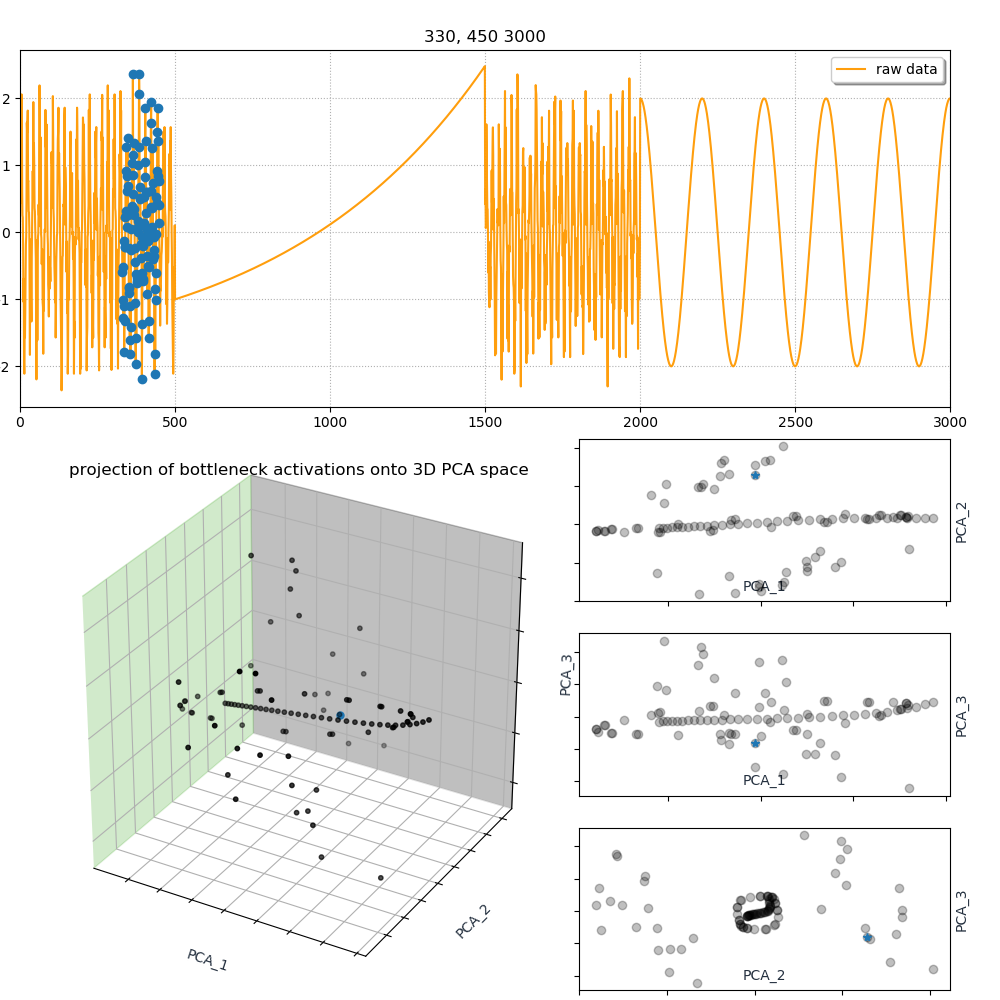

In [36]:
fig = plt.figure(figsize=(10,10))

plt.subplots_adjust( left = 0.02, right = 0.95, top = 0.95, bottom = 0.01, wspace = 0.01 )

ax1 = plt.subplot2grid((5, 5), (0, 0), rowspan=2, colspan=5)
ax1.plot( range(len(targetData)), targetData, color = rawDataColor )
ax1.autoscale(enable=True, axis='x', tight=True)
ax1.legend(['raw data'], loc='upper right', shadow=True)
ax1.grid(linestyle='dotted')

ax2 = plt.subplot2grid((5, 5), (2, 0), rowspan=3, colspan=3, projection='3d')
ax2.scatter(PCA_bottleneckActivations[:, 0], PCA_bottleneckActivations[:,1], PCA_bottleneckActivations[:,2], color=nikeBlack, s=10)
ax2.set_xticklabels([]); ax2.set_yticklabels([]); ax2.set_zticklabels([]);
ax2.set_title('projection of bottleneck activations onto 3D PCA space')
ax2.set_xlabel('PCA_1', color=amazonSquidInk)
ax2.set_ylabel('PCA_2', color=amazonSquidInk)
ax2.set_zlabel('PCA_3', color=amazonSquidInk)

ax2.w_xaxis.set_pane_color(rawDataColor2); ax2.w_yaxis.set_pane_color(contrastColor3); ax2.w_zaxis.set_pane_color((1, 1, 1, .4))

ax3 = plt.subplot2grid((5, 5), (2, 3), rowspan=1, colspan=2)
ax3.plot ( PCA_bottleneckActivations[:,0], PCA_bottleneckActivations[:,1], 'o', color=contrastColor3, picker = 5 )
ax3.set_xticklabels([]); ax3.set_yticklabels([])
ax3.set_xlabel('PCA_1', color=amazonSquidInk); ax3.xaxis.set_label_coords(0.5, 0.13)
ax3.set_ylabel('PCA_2', color=amazonSquidInk); ax3.yaxis.set_label_coords(1.05, 0.5)

ax4 = plt.subplot2grid((5, 5), (3, 3), rowspan=1, colspan=2)
ax4.plot ( PCA_bottleneckActivations[:,0], PCA_bottleneckActivations[:,2], 'o', color=contrastColor3, picker = 5 )
ax4.set_xticklabels([]); ax4.set_yticklabels([])
ax4.set_xlabel('PCA_1', color=amazonSquidInk); ax4.xaxis.set_label_coords(0.5, 0.13)
ax4.set_ylabel('PCA_3', color=amazonSquidInk); ax4.yaxis.set_label_coords(1.05, 0.5)

ax5 = plt.subplot2grid((5, 5), (4, 3), rowspan=1, colspan=2)
ax5.plot ( PCA_bottleneckActivations[:,1], PCA_bottleneckActivations[:,2], 'o', color=contrastColor3, picker = 5 )
ax5.set_xticklabels([]); ax5.set_yticklabels([])
ax5.set_xlabel('PCA_2', color=amazonSquidInk); ax5.xaxis.set_label_coords(0.5, 0.13)
ax5.set_ylabel('PCA_3', color=amazonSquidInk); ax5.yaxis.set_label_coords(1.05, 0.5)


In [37]:
def updatePlots ( ind ):
    if len(ind) > 0:
        targetInd = ind[0]
        lowerBound = max( 0, int((targetInd-2) * hParams['inputOutputDimensionality']) )
        upperBound = min( len(targetData), int((targetInd + 2) * hParams['inputOutputDimensionality']) )
        
        strOut = str(lowerBound) + ', ' + str(upperBound) + ' ' + str(len(targetData))
        ax1.set_title(strOut)        
        
        ax1.plot( list(range( lowerBound, upperBound)), targetData[ lowerBound:upperBound ], 'o' )
        ax2.scatter(PCA_bottleneckActivations[targetInd, 0], PCA_bottleneckActivations[targetInd,1], PCA_bottleneckActivations[targetInd,2], s=25)
        
        ax3.plot ( PCA_bottleneckActivations[targetInd,0], PCA_bottleneckActivations[targetInd,1], '*', picker = 5 )
        ax4.plot ( PCA_bottleneckActivations[targetInd,0], PCA_bottleneckActivations[targetInd,2], '*', picker = 5 )
        ax5.plot ( PCA_bottleneckActivations[targetInd,1], PCA_bottleneckActivations[targetInd,2], '*', picker = 5 )
        


In [38]:
def on_pick(event):
    if event.mouseevent.inaxes != ax2:
        eventArtist = event.artist
        xdata, ydata = eventArtist.get_data()
        ind = event.ind        
        updatePlots(ind)
        
cid = fig.canvas.mpl_connect('pick_event', on_pick)

# End Result

In [ ]:
fig = plt.figure( figsize = (10, 10) ) 
ax = fig.add_subplot(111, projection='3d')
plt.subplots_adjust( left = 0.02, right = 0.95, top = 0.95, bottom = 0.01, wspace = 0.01 )


ax.scatter(PCA_bottleneckActivations[:, 0], PCA_bottleneckActivations[:,1], PCA_bottleneckActivations[:,2], color=rawDataColor, s=10)
ax.scatter(PCA_bottleneckActivations[anomalousInds_1, 0], PCA_bottleneckActivations[anomalousInds_1, 1], PCA_bottleneckActivations[anomalousInds_1, 2], color=anomalyColor1, s = 20)
ax.scatter(PCA_bottleneckActivations[anomalousInds_2, 0], PCA_bottleneckActivations[anomalousInds_2, 1], PCA_bottleneckActivations[anomalousInds_2, 2], color=anomalyColor2, s = 20)

# Appendix - Alternative Dimensionality Reduction Methods

# tSNE 3D

In [ ]:
from sklearn.manifold import TSNE

embeddedBottleneckActivations = TSNE(n_components = 3, perplexity = 6, learning_rate = 10, method='exact', verbose = 1).fit_transform(bottleneckActivations)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.plot(embeddedBottleneckActivations[:,0], embeddedBottleneckActivations[:,1], embeddedBottleneckActivations[:,2], 'bx')
ax.plot(embeddedBottleneckActivations[anomalousInds_1,0], embeddedBottleneckActivations[anomalousInds_1,1], embeddedBottleneckActivations[anomalousInds_1,2], 'rx')
ax.plot(embeddedBottleneckActivations[anomalousInds_2,0], embeddedBottleneckActivations[anomalousInds_2,1], embeddedBottleneckActivations[anomalousInds_2,2], 'ko')
